In [ ]:
# This script, create clusters of a defined area, for the intesection dataset.
# For clustering this script uses the diameter-clustering lib from https://github.com/antklen/diameter-clustering

In [ ]:
!pip install similaritymeasures
!pip install diameter-clustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import similaritymeasures
from diameter_clustering import LeaderClustering
from diameter_clustering import MaxDiameterClustering

import math
from numpy.random import default_rng
import time

from sklearn import preprocessing

In [ ]:

def read_data_from_file(file_name, split=1):
    
    train_file = file_name
    df = pd.read_csv(train_file, sep=',')

    # Select a percentage from full dataset (used in debugging)
    df = df.head(math.floor(df.shape[0]*split))


    return df


def filter_data(df):
    
    # Select cars only
    df = df.loc[df['agent_type'] == "car"]
    return df

def filter_length(df):            
     
    # Select only trajectories with the same length=40 and in the same time phase
 
    g = df.groupby(["object_id"])
 
    g_equal_len = g.filter(lambda x: x['frame_id'].count() == 40) # This works because the recordings are done with a timestamp_max =4000   # and (x['timestamp_ms'].ge(100).any() and x['timestamp_ms'].le(4000).any()))

    return g_equal_len


def compute_distance_matrix(trajectories,x_index,y_index):
    
    n = len(trajectories)
    dist_m = np.zeros((n, n))

    for i in range(n - 1):
        p = trajectories[i]
        p = p[:, [x_index, y_index]]     # Use only x,y columns
        p = np.array(p, dtype=float)

        for j in range(i + 1, n):
            q = trajectories[j]
            q = q[:, [x_index, y_index]] # Use only x,y columns
            q = np.array(q, dtype=float)

            dist_m[i, j] = similaritymeasures.frechet_dist(p, q)
            dist_m[j, i] = dist_m[i, j]
    return dist_m

def max_clustering(distance_matrix, max_radius):
    
    cl = MaxDiameterClustering(max_distance=max_radius,precomputed_dist=True, deterministic=True, sparse_dist=False)
    
    labels = cl.fit_predict(distance_matrix)  
    
    return labels


def cluster_trajectories(df, max_radius, sub_sampling=False):

    # index position of x and y features
    x_index = df.columns.get_loc("x")
    y_index =df.columns.get_loc("y")

    # Convert pandas dataframe to a nested list 

    all_cases = []   #  Multi-dimensional list: ( n_cases, n_tracks, n_steps, n_features)

    case_groups = df.groupby(["case_id"])

    for name, group in case_groups:

        case_tracks = []

        tracks = group.groupby(["object_id"])
    
        for ix,seq in tracks:

            sub_seq = seq.to_numpy()
            # Code here for sub-sampling 5Hz
            if (sub_sampling == True):
                sub_seq = sub_seq[0::2,:]

            case_tracks.append(sub_seq)

        all_cases.append(case_tracks)

    
    clustered_trajectories = []

    # Group trajectories calculating distance matrix and using leader clustering

    for case_n in all_cases:

        distance_matrix = compute_distance_matrix(case_n,x_index,y_index) # send the index of x and y features
        labels = max_clustering(distance_matrix, max_radius=max_radius)
    

        for index, traj in enumerate(case_n):

            label_column = np.full((case_n[index].shape[0]), labels[index])
       
            label_column = np.reshape(label_column,(-1,1)) # Add 1 dimension (row to col)
            trajectory = np.append(traj, label_column, axis=1)  # Insert label column at last position
            
            clustered_trajectories.append(trajectory)

    return clustered_trajectories

def create_clustered_dataset(df, max_radius,split):  

    # Apply clustering to select only near cars
    clustering_result = np.array(cluster_trajectories(df,max_radius=max_radius,sub_sampling=True)) #50 mts
    
    clustering_result = clustering_result.reshape(-1,clustering_result.shape[2]) # Remove the dimension added by grouping by case. 14 is the number of features

    # Save results to new dataset file
    column_names = ['case_id', 'object_id', 'x','y', 'vx', 'vy', 'psi_rad','frame_id','label']
    clustered_df = pd.DataFrame(clustering_result,columns= column_names)

    # Create synthetic variable for easier indexing and search
    clustered_df['cluster_id']=clustered_df['case_id'].astype(int).astype(str)+"-"+clustered_df['label'].astype(str)
    
    # Create a unique identifier for the cluster
    # Notice that this unique cluster identifier n is unique only in the same .csv
    # Consequently it's possible to find the same cluster unique id in the train.csv as in the test.csv

    # Convert to unique object identifier 
    le = preprocessing.LabelEncoder()
    clustered_df['cluster_id'] = le.fit_transform(clustered_df['cluster_id'])

    # Reorder columns
    clustered_df = clustered_df[['case_id', 'object_id', 'cluster_id', 'x','y', 'vx', 'vy', 'psi_rad','frame_id']]
 
    clustered_df.to_csv('/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/DR_USA_Intersection_MA/'+str(max_radius)+'m/'+str(max_radius)+'m-'+split+'.csv',  index = False)

    return clustered_df
    


In [ ]:
# Read full dataset
df = read_data_from_file('/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/DR_USA_Intersection_MA/DR_USA_Intersection_MA.csv', split=1)

# Create a synthetic index variable for easier indexing and search
df['object_id']=df['case_id'].astype(int).astype(str)+"-"+df['track_id'].astype(str)

# Convert to unique object identifier 
le = preprocessing.LabelEncoder()
df['object_id'] = le.fit_transform(df['object_id'])

# Select only vehicles
df = filter_data(df)

# Select only same length sequences
df = filter_length(df)

# Keep only important features
df = df.drop(columns=['track_id','timestamp_ms','agent_type','length','width','frame_id'])

# Reorder columns
df = df[['case_id', 'object_id','x','y', 'vx', 'vy', 'psi_rad','frame_id']]

# Split in training and test set

g = df.groupby(["case_id"])
g_count = g.ngroups

print("Full dataset size: ",g_count)

training_size = math.floor(g_count/100)*80 # 80% for the training size
test_size = g_count - training_size

rng = default_rng(1)
choice = rng.choice(g.ngroups, training_size, replace=False)

# Create the two data splits

g_ngroup = g.ngroup() #assign the group index to each row
training = df[g_ngroup.isin(choice)] # select only training groups
test = df[~g_ngroup.isin(choice)]

training.to_csv('/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/DR_USA_Intersection_MA/train.csv',  index = False)
test.to_csv('/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/DR_USA_Intersection_MA/test.csv',  index = False)

Full dataset size:  5163


In [ ]:
# Load filtered training and test from directory
training = pd.read_csv('/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/DR_USA_Intersection_MA/train.csv', sep=',')
test = pd.read_csv('/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/DR_USA_Intersection_MA/test.csv', sep=',')

In [ ]:
g = training.groupby(["case_id"])
g_count = g.ngroups
print("Training size:", g_count)

g = test.groupby(["case_id"])
g_count = g.ngroups
print("Test size:", g_count)

Training size: 4080
Test size: 1083


In [ ]:
# Create clustered dataset for training
start = time.time()
clustered_training = create_clustered_dataset(training, max_radius=50,split="train")
elapsed = (time.time() - start)


MaxDiameterClustering fit: 100%|██████████| 8/8 [00:00<00:00, 5612.05it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 7/7 [00:00<00:00, 3511.98it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 3/3 [00:00<00:00, 2912.71it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 1/1 [00:00<00:00, 1185.50it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 5/5 [00:00<00:00, 2188.87it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 7/7 [00:00<00:00, 4784.12it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 1/1 [00:00<00:00, 2031.14it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 3/3 [00:00<00:00, 3695.42it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|

In [ ]:
print("Train clustering time:",elapsed)

Train clustering time: 141.78850769996643


In [ ]:
# Create clustered dataset for test
start = time.time()
clustered_test = create_clustered_dataset(test, max_radius=50,split="test")
elapsed = (time.time() - start)


MaxDiameterClustering fit: 100%|██████████| 2/2 [00:00<00:00, 4243.10it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 4/4 [00:00<00:00, 4172.40it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 4/4 [00:00<00:00, 2009.73it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 9/9 [00:00<00:00, 3778.65it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 3/3 [00:00<00:00, 3316.53it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 6/6 [00:00<00:00, 4722.43it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 5/5 [00:00<00:00, 4431.85it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 2/2 [00:00<00:00, 2687.79it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|

In [ ]:
print("Train clustering time:",elapsed)

Train clustering time: 36.6091742515564


In [ ]:
def plot_clusters(clustered_df):

    # display parameters
    a4_dims = (15, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.set_palette("pastel")


    # Display how many clusters were created, and its elements
    case_id = clustered_df.groupby(["cluster_id"])


    g = []

    for ix,element in case_id:
        l = element.groupby(["object_id"])

        g.append(len(l))

    print("max number of cars by cluster: ", max(g))
    print("number of clusters:", len(g)) 

    ax = sns.histplot(ax=ax, data=g, discrete=True, shrink=.8)
    ax.set(xlabel='number of interacting vehicles', ylabel='number of groups')

In [ ]:
# Load already pre-computed clustered dataset (TRAIN)
clustered_df_train = pd.read_csv('/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/DR_USA_Intersection_MA/50m/50m-train.csv', sep=',')


In [ ]:
# Show number of trajectories length
g = clustered_df_train.groupby(["object_id"])
c = g.count()
print("Number of trajectories in train: ",c.shape[0])

Number of trajectories in train:  31778


max number of cars by cluster:  12
number of clusters: 8572


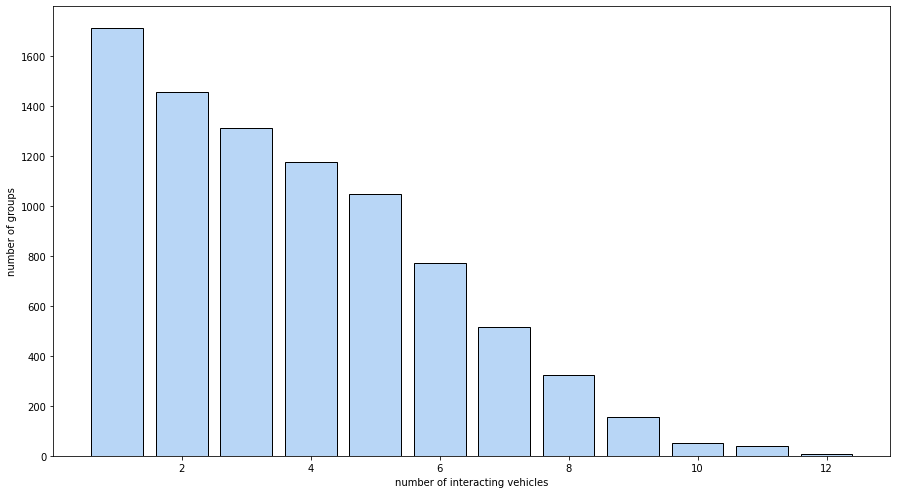

In [ ]:
plot_clusters(clustered_df_train)

In [ ]:
# Load already pre-computed clustered dataset (TEST)
clustered_df_test = pd.read_csv('/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/DR_USA_Intersection_MA/50m/50m-test.csv', sep=',')


In [ ]:
# Show number of trajectories length
g = clustered_df_test.groupby(["object_id"])
c = g.count()
print("Number of trajectories in test: ",c.shape[0])

Number of trajectories in test:  8450


max number of cars by cluster:  12
number of clusters: 2300


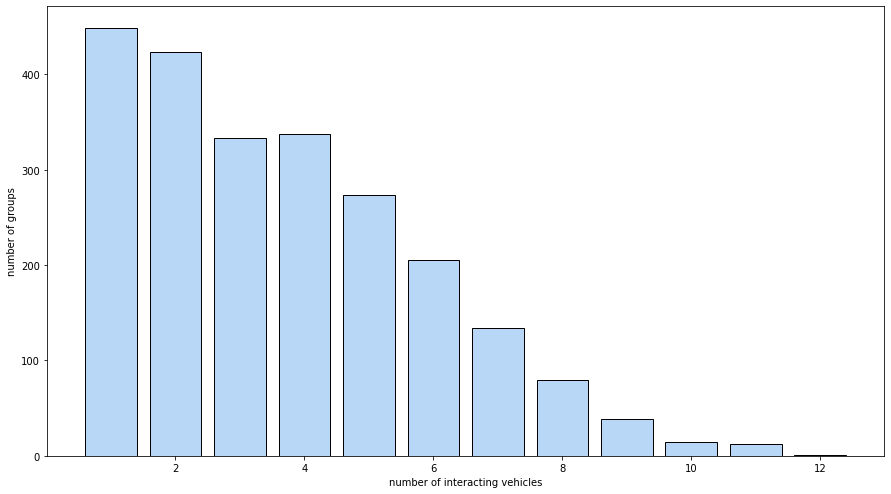

In [ ]:
plot_clusters(clustered_df_test)

In [ ]:
clustered_df_train.head(5)

,case_id,object_id,cluster_id,x,y,vx,vy,psi_rad,frame_id
0,1.0,0.0,0,1005.989,999.625,6.367,-0.230,-0.036,1.0
1,1.0,0.0,0,1007.291,999.588,6.930,-0.207,-0.030,3.0
2,1.0,0.0,0,1008.705,999.556,7.473,-0.183,-0.024,5.0
3,1.0,0.0,0,1010.226,999.527,7.988,-0.159,-0.020,7.0
4,1.0,0.0,0,1011.848,999.502,8.467,-0.136,-0.016,9.0


**FILTER BY NUMBER OF CARS IN CLUSTER**

In [ ]:
def create_filtered_dataset(df, max_cars, max_radius,split):

    column_names = list(df.columns)

    filtered = []
    
    case_id = df.groupby(["cluster_id"])


    for ix,element in case_id:
        l = element.groupby(["object_id"])
        if(len(l)==max_cars): # number of interacting vehicles
            for iy,e in l:
                filtered.append(e.values.tolist())

    # Convert list results to array
    filtered_array = np.array(filtered)

    filtered_array = filtered_array.reshape(-1,filtered_array.shape[2]) # Remove the dimension added by grouping by case. 15 is the number of features

    filtered_df = pd.DataFrame(filtered_array,columns= column_names)

    # Types of columns
    filtered_df.object_id = filtered_df.object_id.astype('int64')
    filtered_df.cluster_id = filtered_df.cluster_id.astype('int64')
    filtered_df.case_id = filtered_df.case_id.astype('int64')

    filtered_df.drop(columns=['frame_id'],inplace=True)
  
    # Save filtered dataset to file
    filtered_df.to_csv('/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/DR_USA_Intersection_MA/'+str(max_radius)+"m/"+str(max_radius)+'m-'+str(max_cars)+'c-'+split+'.csv',  index = False)
   




In [ ]:
create_filtered_dataset(clustered_df_train, max_cars = 6, max_radius=50, split="train")
create_filtered_dataset(clustered_df_test, max_cars = 6, max_radius=50, split="test")